In [312]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

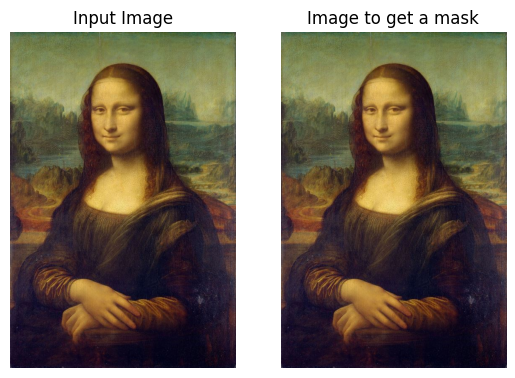

In [313]:
input_image_path = "monalisa.jpeg" 
mask_image_path = "monalisa.jpeg" 

input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(mask_image_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.title('Image to get a mask')
plt.axis('off')  # Turn off axis labels
plt.show()


In [314]:
def getMask(mask_image):
    # Get the ROI using cv2.selectROI
    rect_roi = cv2.selectROI(mask_image)
    cv2.destroyAllWindows()

    return input_image[int(rect_roi[1]):int(rect_roi[1]+rect_roi[3]),
                int(rect_roi[0]):int(rect_roi[0]+rect_roi[2])] 

def getRegionToMask(input_image):
    rect_roi = cv2.selectROI(input_image)
    cv2.destroyAllWindows()

    return rect_roi

def setMaskImage(mask_image, region_to_mask, mask):   

    # Create a white image
    result_image = np.copy(mask_image)

    # Calculate the center of the region_to_mask
    center_x = int(region_to_mask[0] + region_to_mask[2] / 2)
    center_y = int(region_to_mask[1] + region_to_mask[3] / 2)

    # Calculate the position to place the mask in the new image
    start_x = center_x - int(mask.shape[1] / 2)
    start_y = center_y - int(mask.shape[0] / 2)

    # Create a new image with the mask placed in the specified region
    result_image[start_y:start_y + mask.shape[0], start_x:start_x + mask.shape[1]] = mask

    # Create mask for blending image as black and white
    mask_for_blending = np.zeros_like(mask_image, dtype=float)
    mask_for_blending[start_y:start_y + mask.shape[0], start_x:start_x + mask.shape[1]] = 1
    return result_image, mask_for_blending

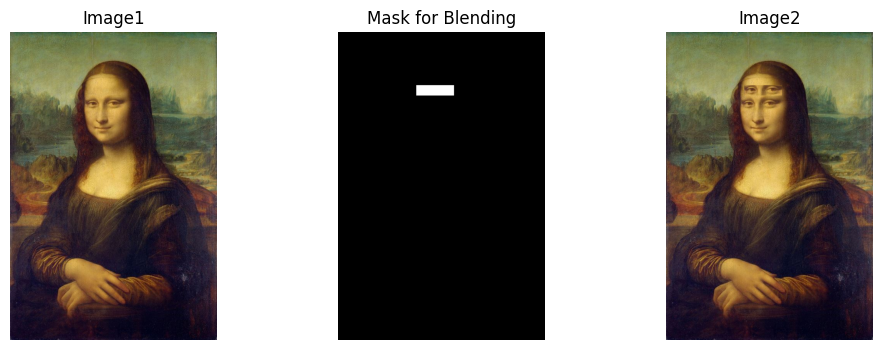

In [315]:
# Get the mask from the mask image (second image)
mask = getMask(mask_image)

# Get the region to mask from input image (first image)
region_to_mask = getRegionToMask(input_image)

image1 = input_image
image2, mask_for_blending = setMaskImage(mask_image, region_to_mask, mask)

#mask_for_blending = np.zeros_like(input_image[:, :, 0]) 

#mask_for_blending[int(region_to_mask[1]):int(region_to_mask[1] + region_to_mask[3]),
 #    int(region_to_mask[0]):int(region_to_mask[0] + region_to_mask[2])] = 255

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image1, cmap='gray')
plt.title("Image1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_for_blending, cmap='gray')
plt.title("Mask for Blending")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image2, cmap='gray')
plt.title("Image2")
plt.axis('off')

plt.show()

In [316]:
mask_for_blending
image1 = image1.astype(np.float64) / 255.0
image2 = image2.astype(np.float64) / 255.0

In [317]:
def generate_gaussian_pyramid(image, levels):
    levels = int(np.floor(np.log2(min(image.shape[0], image.shape[1]))))
    gaussian_pyramid = [image]
    for _ in range(levels - 1):
        image = cv2.GaussianBlur(image, (5, 5), 0)
        image = image[::2, ::2]  # Subsampling
        gaussian_pyramid.append(image)
    return gaussian_pyramid

def generate_laplacian_pyramid(image):
    levels = int(np.floor(np.log2(min(image.shape[0], image.shape[1]))))  # Number of pyramid levels
    gaussian_pyramid = generate_gaussian_pyramid(image, levels)
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]

    for i in range(levels - 1, 0, -1):
        expanded = cv2.resize(gaussian_pyramid[i], (gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0]))
        laplacian = gaussian_pyramid[i - 1] - expanded
        laplacian_pyramid.insert(0, laplacian)

    return laplacian_pyramid

def collapse_laplacian_pyramid(laplacian_pyramid):
    levels = len(laplacian_pyramid)
    if levels == 1:
        return laplacian_pyramid[0]

    reconstructed = laplacian_pyramid[levels - 1]

    for i in range(levels - 2, -1, -1):
        expanded = cv2.resize(reconstructed, (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]))
        reconstructed = laplacian_pyramid[i] + expanded

    return reconstructed

In [318]:
def blend_images(image1, image2, mask_for_blending):

    # Create Laplacian pyramids for both images
    laplacian_pyramid1 = generate_laplacian_pyramid(image1)
    laplacian_pyramid2 = generate_laplacian_pyramid(image2)

    # Initialize the blended pyramid
    blended_pyramid = []

    Rgaus = generate_gaussian_pyramid(mask_for_blending, 5)

    # Blend each level of the pyramid using the region mask
    for i in range(len(laplacian_pyramid1)):
        # Get the Laplacian pyramid at level i for both images
        Li1 = laplacian_pyramid1[i]
        Li2 = laplacian_pyramid2[i]

        # Get the region mask at level i
        Ri = Rgaus[i]

        # Blend the images at level i
        Li12 = Li1 * Ri + Li2 * (1 - Ri)

        # Append the blended level to the blended pyramid
        blended_pyramid.append(Li12)

    # Collapse the blended pyramid to obtain the final blended image
    final_blended_image = collapse_laplacian_pyramid(blended_pyramid)

    return final_blended_image

In [319]:
blended = blend_images(image2,image1,mask_for_blending)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 536.5, 799.5, -0.5)

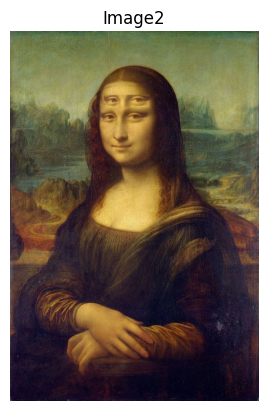

In [322]:
plt.imshow(blended)
plt.title("Image2")
plt.axis('off')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


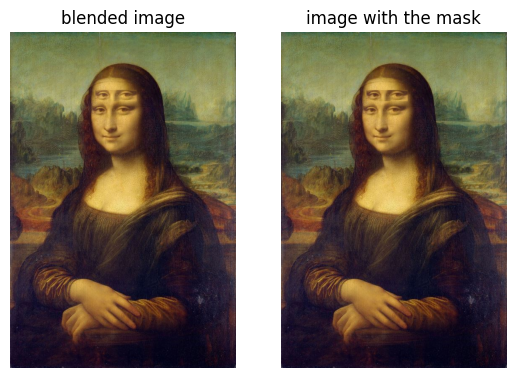

In [321]:
plt.subplot(1, 2, 1)
plt.imshow(blended)
plt.title('blended image')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('image with the mask')
plt.axis('off')  # Turn off axis labels
plt.show()